In [222]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [223]:
%pip install transformers --quiet

In [224]:
%pip install gensim nltk pandas numpy tensorflow scikit-learn matplotlib seaborn --quiet

In [225]:
import warnings
warnings.filterwarnings("ignore")

In [226]:
import os
os.makedirs("./Results/Malayalam", exist_ok=True)

## Ingestion and Visualisation

In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [228]:
# Load datasets
import pandas as pd
mal_train_df = pd.read_csv("/content/mal_fake_dev.csv")
mal_test_df = pd.read_csv("/content/mal_fake_test_with_labels.csv")
mal_val_df = pd.read_csv("/content/mal_fake_train (1).csv")

In [229]:
# Combine datasets
dataset = pd.concat([mal_train_df, mal_test_df, mal_val_df], ignore_index=True)
dataset.head()

,Unnamed: 0,text,label
0,2535.0,കുറെ പേർക്ക് കുരു പൊട്ടാൻ സാധ്യത ഉണ്ട്..,Fake
1,4059.0,പോടനായെ,original
2,2310.0,ചൈന തയോളികൾ,Fake
3,2202.0,കൊറോണ നാട്ടിൽ കൂടുക ആണല്ലോ ഇവറ്റകളുടെ ലക്ഷ്യം,original
4,4215.0,ഇത്‌ എഴുതിയവന്റെ കൈ തല്ലിയൊടിക്കണം ....ഇനി മേല...,original


In [230]:
dataset = dataset[['text', 'label']]
dataset.dropna(inplace=True)

dataset.drop_duplicates(inplace=True, ignore_index=True)
dataset.reset_index(drop=True, inplace=True)
dataset.shape

(4952, 2)

In [231]:
dataset['label'].value_counts()

label
Fake        2490
original    2462
Name: count, dtype: int64

In [232]:
def plot_sequence_word_counts(sequences):
    word_counts = [len(sequence.split()) for sequence in sequences]

    min_length_index = word_counts.index(min(word_counts))
    max_length_index = word_counts.index(max(word_counts))

    print("Minimum length of sequence:", len(sequences[min_length_index]), " - index: ", min_length_index)
    print("Maximum length of sequence:", len(sequences[max_length_index]), " - index: ", max_length_index)
    print("Sequence average length: ", sum(word_counts)/len(sequences))

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.histplot(word_counts, bins=20, kde=False, color="skyblue")

    plt.xlabel("Word Count")
    plt.ylabel("Frequency")
    plt.title("Histogram of Word Counts for Sequences")
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxenplot(word_counts)
    plt.ylabel("Word Counts")
    plt.title("Box Plot of Word Counts for Sequences")
    plt.show()

Minimum length of sequence: 7  - index:  1
Maximum length of sequence: 2609  - index:  1875
Sequence average length:  11.297253634894991


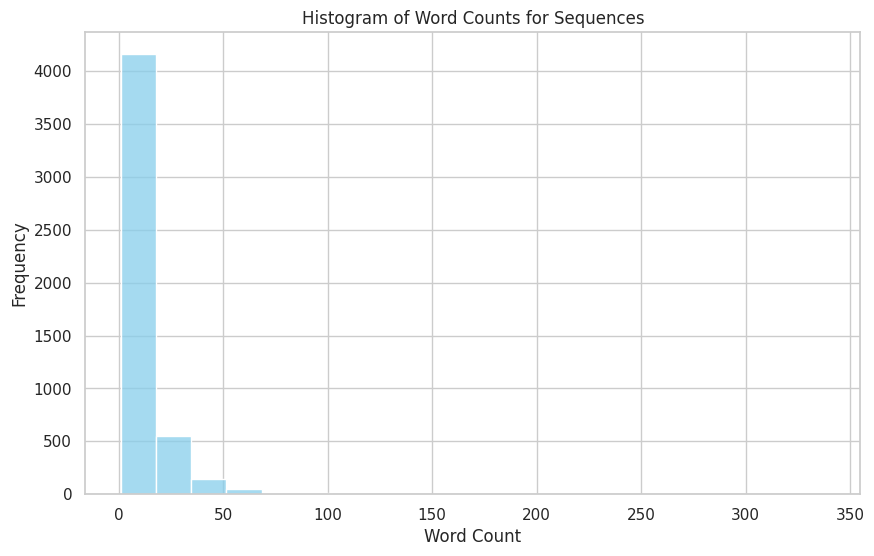

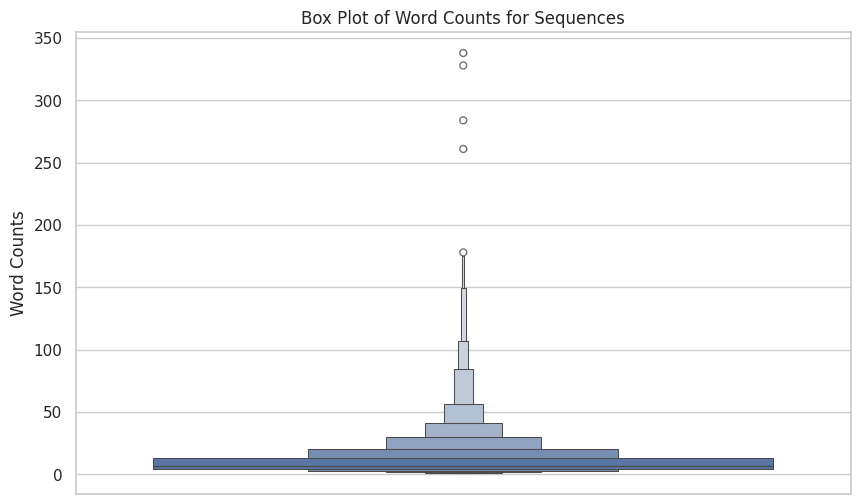

In [233]:
plot_sequence_word_counts(dataset['text'].tolist())

In [234]:
from random import choice

for _ in range(1):
    index = choice(range(len(dataset)))

    print("Text - ", dataset['text'][index])
    print("\nLabel - ", dataset['label'][index])
    print("\n\n\n")

Text -  മാധ്യമരംഗത്തെ റോസ്റ്റിങ് അർജു🔥

Label -  original






## Preprocessing

In [235]:
dataset['length'] = dataset['text'].apply(lambda x: len(x.split(" ")))

In [236]:
dataset = dataset[dataset['length'] < 30]

In [237]:
dataset['label'].value_counts()

label
original    2384
Fake        2208
Name: count, dtype: int64

In [238]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(dataset, test_size=0.2, random_state=42)
train_df.shape, test_df.shape

((3673, 3), (919, 3))

In [239]:
train_df['label'].value_counts()

label
original    1889
Fake        1784
Name: count, dtype: int64

In [240]:
test_df['label'].value_counts()

label
original    495
Fake        424
Name: count, dtype: int64

In [241]:
y_train_raw = train_df['label'].replace(["original", "Fake"], [0, 1]).to_numpy()
y_test_raw = test_df['label'].replace(["original", "Fake"], [0, 1]).to_numpy()

In [242]:
import numpy as np

y_train = [[0, 0] for _ in range(len(y_train_raw))]
for i, j in enumerate(y_train_raw):
    y_train[i][j] = 1  # j is already the index (0 or 1)
y_train = np.array(y_train, dtype=np.float32)

y_test = [[0, 0] for _ in range(len(y_test_raw))]
for i, j in enumerate(y_test_raw):
    y_test[i][j] = 1  # j is already the index (0 or 1)
y_test = np.array(y_test, dtype=np.float32)

In [243]:
y_train.shape, y_train[0]

((3673, 2), array([1., 0.], dtype=float32))

## BERT

In [244]:
from transformers import AutoTokenizer, TFAutoModel

model_name = "bert-base-multilingual-cased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModel.from_pretrained(model_name)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [245]:
from tqdm import tqdm

MAX_SEQ_LEN = 32

train_sequences = train_df['text'].tolist()
test_sequences = test_df['text'].tolist()

In [246]:
sample = train_sequences[0]

tokens = tokenizer(sample, return_tensors="tf", padding="max_length", # It will do the padding and truncation according to MAX_LENGTH
                  max_length=MAX_SEQ_LEN, truncation=True)
tokens

{'input_ids': <tf.Tensor: shape=(1, 32), dtype=int32, numpy=
array([[  101, 63808, 13005, 98013, 10112, 10144, 13641, 34891, 79313,
        11591,   100,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 32), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 32), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>}

In [247]:
embedding = model.bert(**tokens).last_hidden_state[0]
embedding

<tf.Tensor: shape=(32, 768), dtype=float32, numpy=
array([[-0.14401855,  0.10089712,  0.18056183, ...,  0.02070437,
         0.09997058, -0.13858134],
       [-0.40475535, -0.62465334,  0.11535794, ..., -0.19366829,
         0.16337124,  0.08897245],
       [-0.8800783 , -0.47413728,  0.01672086, ..., -1.0376315 ,
         0.4891776 , -0.13751106],
       ...,
       [-0.07659303,  0.07679991,  0.25817087, ...,  0.2417214 ,
         0.09527288, -0.20176417],
       [-0.1095379 ,  0.02748973,  0.27621782, ...,  0.17418478,
         0.04412793, -0.23467518],
       [-0.13628392,  0.02301504,  0.27775908, ...,  0.1772585 ,
         0.04460238, -0.22068295]], dtype=float32)>

In [248]:
import tensorflow as tf

def prepare_embeddings(sequences: list[str]):
    embeddings = []
    for sequence in tqdm(sequences, total=len(sequences)):
        tokens = tokenizer(sequence, return_tensors="tf", padding='max_length',
                           max_length=MAX_SEQ_LEN, truncation=True)
        embedding = model.bert(**tokens).last_hidden_state[0]
        embeddings.append(embedding)

    return tf.convert_to_tensor(embeddings)

In [249]:
X_train = prepare_embeddings(train_sequences)
X_train.shape

100%|██████████| 3673/3673 [30:36<00:00,  2.00it/s]


TensorShape([3673, 32, 768])

In [250]:
X_test = prepare_embeddings(test_sequences)
X_test.shape

100%|██████████| 919/919 [07:17<00:00,  2.10it/s]


TensorShape([919, 32, 768])

In [251]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

def evaluate(y_pred):
    y_pred = y_pred[:, 1]
    accuracy = accuracy_score(y_test[:, 1], y_pred)
    precision = precision_score(y_test[:, 1], y_pred)
    recall = recall_score(y_test[:, 1], y_pred)
    f1 = f1_score(y_test[:, 1], y_pred)
    roc_auc = roc_auc_score(y_test[:, 1], y_pred)

    print("Accuracy - {:.4f}".format(accuracy))
    print("Precision - {:.4f}".format(precision))
    print("Recall - {:.4f}".format(recall))
    print("F1 - {:.4f}".format(f1))
    #print("ROC-AUC - {:.4f}".format(roc_auc))

    cm = confusion_matrix(y_test[:, 1], y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        #"ROC-AUC": roc_auc
    }

In [252]:
model_scores = []

In [253]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['text'])
sequences = tokenizer.texts_to_sequences(dataset['text'])
data = pad_sequences(sequences)

## Logistic Regression

In [254]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import choice
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertTokenizer, BertModel
import torch

In [255]:
def evaluate1(y_pred):
    accuracy = accuracy_score(y_test_1d, y_pred) # Use y_test_1d which is a 1D array
    # accuracy = accuracy_score(y_test, y_pred) # Remove this line as it causes error
    precision = precision_score(y_test_1d, y_pred) # Use y_test_1d
    recall = recall_score(y_test_1d, y_pred) # Use y_test_1d
    f1 = f1_score(y_test_1d, y_pred) # Use y_test_1d
    # roc_auc = roc_auc_score(y_test, y_pred) # ROC-AUC score is not applicable for multi-class classification
    cm = confusion_matrix(y_test_1d, y_pred) # Use y_test_1d
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    print("Accuracy - {:.4f}".format(accuracy))
    print("Precision - {:.4f}".format(precision))
    print("Recall - {:.4f}".format(recall))
    print("F1 - {:.4f}".format(f1))
    # print("ROC-AUC - {:.4f}".format(roc_auc)) # Remove ROC-AUC score

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1} # Remove ROC-AUC score

## Logistic Regression

In [256]:
# Assuming y_train is a 2D array with one-hot encoded labels
y_train_1d = np.argmax(y_train, axis=1)  # Convert to 1D array of labels

# Initialize the logistic regression model
model = LogisticRegression()

# Train the model using the 1D target array
model.fit(X_train_flattened, y_train_1d)

# Make predictions (use flattened X_test)
y_pred = model.predict(X_test_flattened)

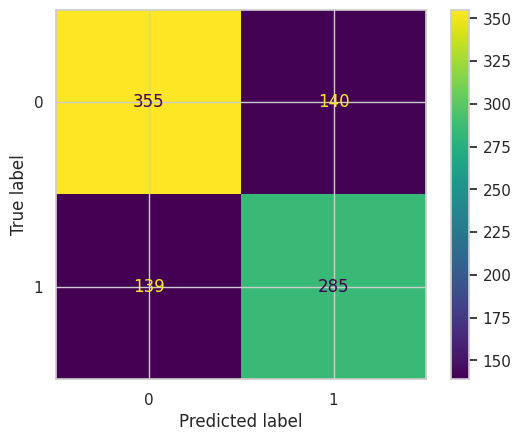

Accuracy - 0.6964
Precision - 0.6706
Recall - 0.6722
F1 - 0.6714


In [257]:
scores = evaluate1(y_pred)  # Assuming 'evaluate' function is defined elsewhere
scores['model'] = "Logistic Regression"
model_scores.append(scores)

## KNN

In [258]:
# Assuming X_train is also an EagerTensor of shape (num_samples, 32, 768)
X_train_flattened = X_train.numpy().reshape(X_train.shape[0], -1)  # Flatten the embeddings
X_test_flattened = X_test.numpy().reshape(X_test.shape[0], -1)

# Initialize the KNN model
model = KNeighborsClassifier()

# Train the model using the 1D target array (same as for Logistic Regression)
model.fit(X_train_flattened, y_train_1d)  # Use y_train_1d

# Make predictions (use flattened X_test)
y_pred = model.predict(X_test_flattened)

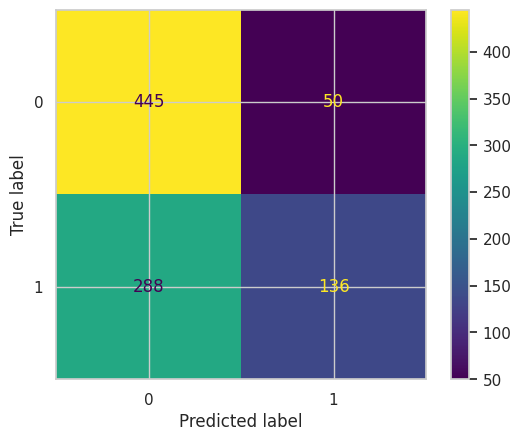

Accuracy - 0.6322
Precision - 0.7312
Recall - 0.3208
F1 - 0.4459


In [259]:
scores = evaluate1(y_pred)
scores['model'] = "KNN"
model_scores.append(scores)

## Naive Bayes

In [260]:
# Bernoulli Naive Bayes
from sklearn.naive_bayes import BernoulliNB
model_bnb = BernoulliNB()

# Assuming y_train is one-hot encoded, convert to 1D array of labels
y_train_1d = np.argmax(y_train, axis=1)

model_bnb.fit(X_train_flattened, y_train_1d) # Use the 1D labels
y_pred_bnb = model_bnb.predict(X_test_flattened)

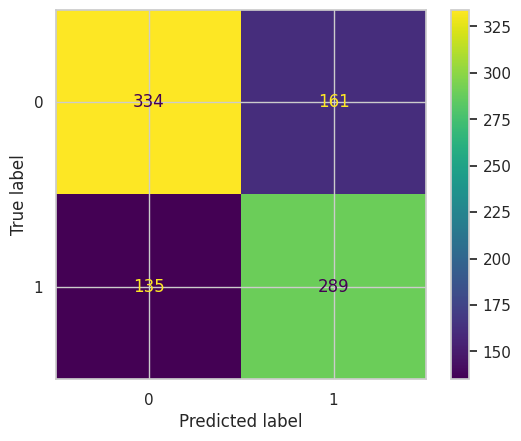

Accuracy - 0.6779
Precision - 0.6422
Recall - 0.6816
F1 - 0.6613


In [261]:
scores_bnb = evaluate1(y_pred_bnb)
scores_bnb['model'] = "Bernoulli Naive Bayes"
model_scores.append(scores_bnb)

## Decision Tree

In [262]:
def evaluate2(y_pred):
    # Convert y_pred to 1D array of predicted labels
    y_pred_1d = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_test_1d, y_pred_1d)
    precision = precision_score(y_test_1d, y_pred_1d)
    recall = recall_score(y_test_1d, y_pred_1d)
    f1 = f1_score(y_test_1d, y_pred_1d)
    cm = confusion_matrix(y_test_1d, y_pred_1d) # Use y_pred_1d here as well
    # roc_auc = roc_auc_score(y_test, y_pred) # ROC-AUC score is not applicable for multi-class
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    print("Accuracy - {:.4f}".format(accuracy))
    print("Precision - {:.4f}".format(precision))
    print("Recall - {:.4f}".format(recall))
    print("F1 - {:.4f}".format(f1))
    # print("ROC-AUC - {:.4f}".format(roc_auc)) # Remove ROC-AUC score

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1} # Remove ROC-AUC score

In [263]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree model
model_dt = DecisionTreeClassifier()

# Train the model
model_dt.fit(X_train_flattened, y_train)

# Make predictions
y_pred_dt = model_dt.predict(X_test_flattened)

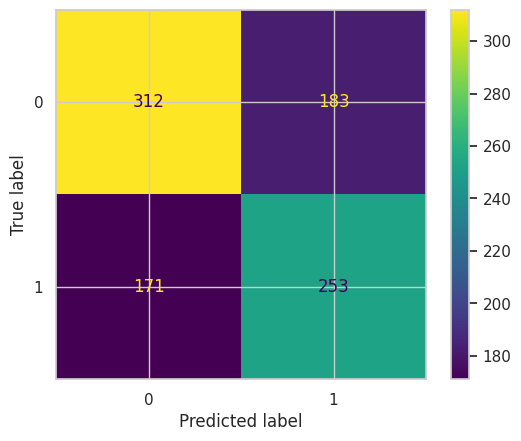

Accuracy - 0.6148
Precision - 0.5803
Recall - 0.5967
F1 - 0.5884


In [264]:
scores_dt = evaluate2(y_pred_dt)
scores_dt['model'] = "Decision Tree"
model_scores.append(scores_dt)

## SVM

In [265]:
import numpy as np

if y_train.ndim == 2:
    y_train = np.argmax(y_train, axis=1)
if y_test.ndim == 2:
    y_test = np.argmax(y_test, axis=1)
from sklearn.svm import SVC

# Initialize the SVM model
model_svm = SVC()

# Train the model
model_svm.fit(X_train_flattened, y_train)

# Make predictions
y_pred_svm = model_svm.predict(X_test_flattened)


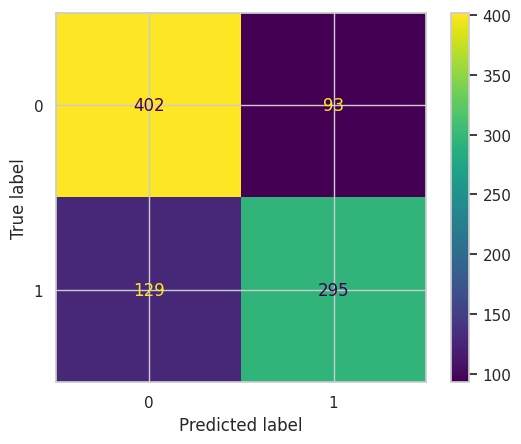

Accuracy - 0.7584
Precision - 0.7603
Recall - 0.6958
F1 - 0.7266


In [266]:
scores_svm = evaluate1(y_pred_svm)
scores_svm['model'] = "SVM"
model_scores.append(scores_svm)

## Random Forest

In [267]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
model_rf = RandomForestClassifier()

# Train the model
model_rf.fit(X_train_flattened, y_train)

# Make predictions
y_pred_rf = model_rf.predict(X_test_flattened)

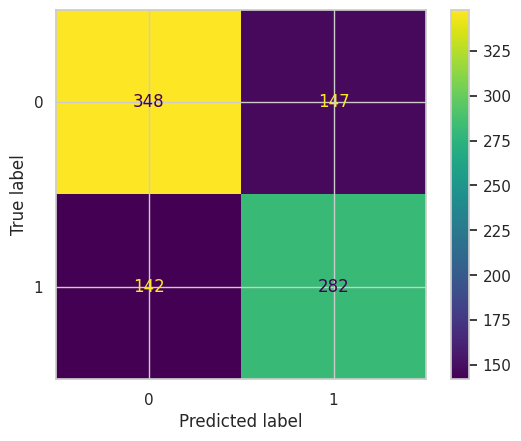

Accuracy - 0.6855
Precision - 0.6573
Recall - 0.6651
F1 - 0.6612


In [268]:
scores_rf = evaluate1(y_pred_rf)
scores_rf['model'] = "Random Forest"
model_scores.append(scores_rf)

## Feed Forward Network

In [269]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Conv2D, MaxPool2D, Flatten, Bidirectional, Dropout, Reshape, Concatenate, Input

ffn = tf.keras.Sequential([
    Input(shape=(MAX_SEQ_LEN, 768)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid') # Change to a single output with sigmoid
])

ffn.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
history = ffn.fit(X_train, y_train, epochs=5)

Epoch 1/5
115/115 [==============================] - 5s 39ms/step - loss: 0.8007 - accuracy: 0.6099
Epoch 2/5
115/115 [==============================] - 4s 38ms/step - loss: 0.5798 - accuracy: 0.7354
Epoch 3/5
115/115 [==============================] - 6s 52ms/step - loss: 0.4496 - accuracy: 0.7901
Epoch 4/5
115/115 [==============================] - 4s 38ms/step - loss: 0.3407 - accuracy: 0.8582
Epoch 5/5
115/115 [==============================] - 5s 41ms/step - loss: 0.2868 - accuracy: 0.8884


29/29 [==============================] - 0s 8ms/step


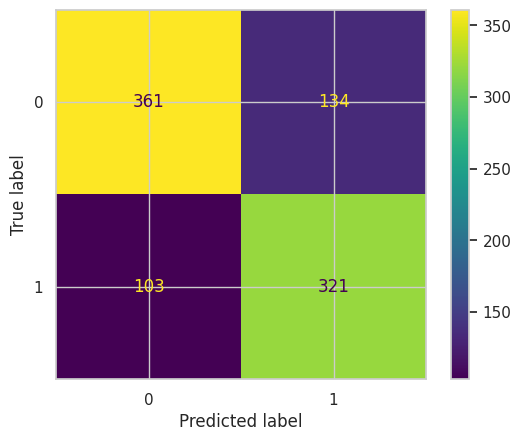

Accuracy - 0.7421
Precision - 0.7055
Recall - 0.7571
F1 - 0.7304


In [270]:
y_pred = np.round(ffn.predict(X_test))
scores = evaluate1(y_pred)
scores['model'] = "ffn"
model_scores.append(scores)

## LSTM

In [271]:
lstm = tf.keras.Sequential([
    LSTM(64, return_sequences=True),
    LSTM(64, return_sequences=True),
    LSTM(64, return_sequences=True),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Change to sigmoid for binary classification
])

lstm.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

lstm.fit(X_train, y_train, epochs=5)

Epoch 1/5
115/115 [==============================] - 17s 114ms/step - loss: 0.5861 - accuracy: 0.6880
Epoch 2/5
115/115 [==============================] - 11s 95ms/step - loss: 0.4881 - accuracy: 0.7661
Epoch 3/5
115/115 [==============================] - 9s 77ms/step - loss: 0.4356 - accuracy: 0.8067
Epoch 4/5
115/115 [==============================] - 11s 95ms/step - loss: 0.3600 - accuracy: 0.8391
Epoch 5/5
115/115 [==============================] - 13s 114ms/step - loss: 0.3133 - accuracy: 0.8582


29/29 [==============================] - 1s 31ms/step


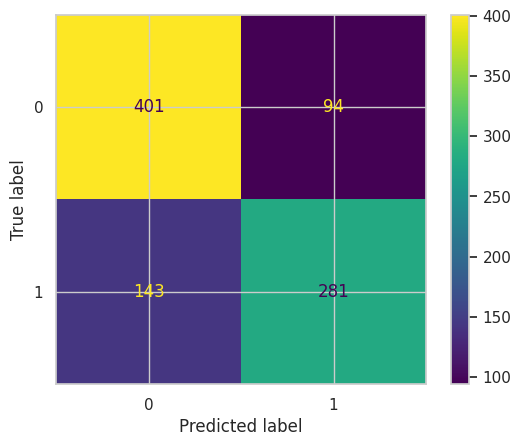

Accuracy - 0.7421
Precision - 0.7493
Recall - 0.6627
F1 - 0.7034


In [272]:
y_pred = np.round(lstm.predict(X_test))
scores = evaluate1(y_pred)
scores['model'] = "lstm"
model_scores.append(scores)

## BiLSTM

In [273]:
bilstm = tf.keras.Sequential([
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64, return_sequences=True)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Change to a single unit with sigmoid for binary classification
])

bilstm.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

bilstm.fit(X_train, y_train, epochs=5)

Epoch 1/5
115/115 [==============================] - 30s 170ms/step - loss: 0.5858 - accuracy: 0.6978
Epoch 2/5
115/115 [==============================] - 19s 168ms/step - loss: 0.4937 - accuracy: 0.7615
Epoch 3/5
115/115 [==============================] - 22s 189ms/step - loss: 0.4215 - accuracy: 0.8040
Epoch 4/5
115/115 [==============================] - 20s 171ms/step - loss: 0.3572 - accuracy: 0.8399
Epoch 5/5
115/115 [==============================] - 19s 170ms/step - loss: 0.3089 - accuracy: 0.8680


29/29 [==============================] - 4s 92ms/step


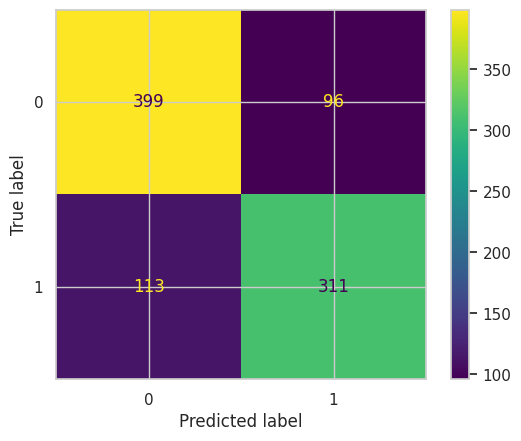

Accuracy - 0.7726
Precision - 0.7641
Recall - 0.7335
F1 - 0.7485


In [274]:
y_pred = np.round(bilstm.predict(X_test))
scores = evaluate1(y_pred)
scores['model'] = "bilstm"
model_scores.append(scores)

## CNN

In [275]:
cnn = tf.keras.Sequential([
    Input(shape=(MAX_SEQ_LEN, 768)),
    Reshape((MAX_SEQ_LEN, 768, 1)),
    Conv2D(64, kernel_size=(3, 768), padding="valid",
           kernel_initializer="normal", activation='relu'),
    MaxPool2D((2, 1), (2, 1)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Change to a single unit with sigmoid for binary classification
])

cnn.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

cnn.fit(X_train, y_train, epochs=5)

Epoch 1/5
115/115 [==============================] - 4s 29ms/step - loss: 0.6267 - accuracy: 0.6572
Epoch 2/5
115/115 [==============================] - 3s 30ms/step - loss: 0.4664 - accuracy: 0.7748
Epoch 3/5
115/115 [==============================] - 5s 46ms/step - loss: 0.3655 - accuracy: 0.8366
Epoch 4/5
115/115 [==============================] - 3s 29ms/step - loss: 0.2718 - accuracy: 0.8884
Epoch 5/5
115/115 [==============================] - 3s 29ms/step - loss: 0.1723 - accuracy: 0.9360


29/29 [==============================] - 0s 8ms/step


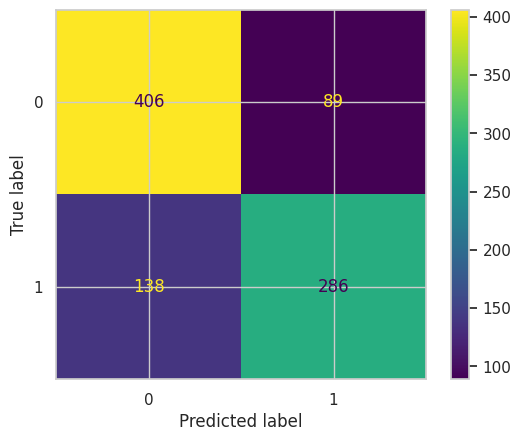

Accuracy - 0.7530
Precision - 0.7627
Recall - 0.6745
F1 - 0.7159


In [276]:
y_pred = np.round(cnn.predict(X_test))
scores = evaluate1(y_pred)
scores['model'] = "cnn"
model_scores.append(scores)

## RNN

In [277]:
from tensorflow.keras.layers import SimpleRNN

# Define the RNN model
model_rnn = tf.keras.Sequential([  # Change variable name to model_rnn
    Input(shape=(MAX_SEQ_LEN, 768)),
    SimpleRNN(128, return_sequences=True),  # RNN layer with 128 units
    SimpleRNN(128),  # Another RNN layer
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Change to a single unit with sigmoid for binary classification
])

model_rnn.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

model_rnn.fit(X_train, y_train, epochs=5) # Fit the model_rnn variable

Epoch 1/5
115/115 [==============================] - 8s 44ms/step - loss: 0.6440 - accuracy: 0.6316
Epoch 2/5
115/115 [==============================] - 4s 39ms/step - loss: 0.5588 - accuracy: 0.7147
Epoch 3/5
115/115 [==============================] - 7s 59ms/step - loss: 0.5367 - accuracy: 0.7389
Epoch 4/5
115/115 [==============================] - 5s 39ms/step - loss: 0.4866 - accuracy: 0.7691
Epoch 5/5
115/115 [==============================] - 4s 39ms/step - loss: 0.4135 - accuracy: 0.8138


In [278]:
def evaluate3(y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred) # Use y_pred directly as it's 1D
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    print("Accuracy - {:.4f}".format(accuracy))
    print("Precision - {:.4f}".format(precision))
    print("Recall - {:.4f}".format(recall))
    print("F1 - {:.4f}".format(f1))

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1}

29/29 [==============================] - 1s 15ms/step


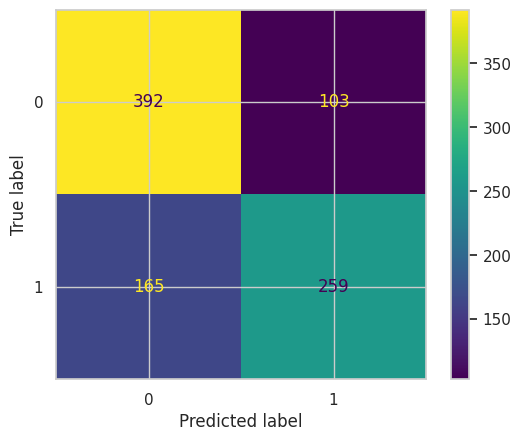

Accuracy - 0.7084
Precision - 0.7155
Recall - 0.6108
F1 - 0.6590


In [279]:
y_pred = np.round(model_rnn.predict(X_test)) # Use model_rnn instead of rnn
scores = evaluate3(y_pred[:, 0]) # Index to get the first column of predictions
scores['model'] = "rnn"
model_scores.append(scores)

In [280]:
model_scores_df = pd.DataFrame(model_scores)
model_scores_df

,accuracy,precision,recall,f1,model
0,0.696409,0.670588,0.672170,0.671378,Logistic Regression
1,0.632209,0.731183,0.320755,0.445902,KNN
2,0.677911,0.642222,0.681604,0.661327,Bernoulli Naive Bayes
3,0.614799,0.580275,0.596698,0.588372,Decision Tree
4,0.758433,0.760309,0.695755,0.726601,SVM
5,0.685528,0.657343,0.665094,0.661196,Random Forest
6,0.742111,0.705495,0.757075,0.730375,ffn
7,0.742111,0.749333,0.662736,0.703379,lstm
8,0.772579,0.764128,0.733491,0.748496,bilstm
9,0.752992,0.762667,0.674528,0.715895,cnn


In [281]:
model_scores_df.to_csv("./Results/Malayalam/bert.csv")

## Visualization of Results

In [282]:
base_path = "./Results/Malayalam/"

bert_scores = pd.read_csv(base_path + "bert.csv")

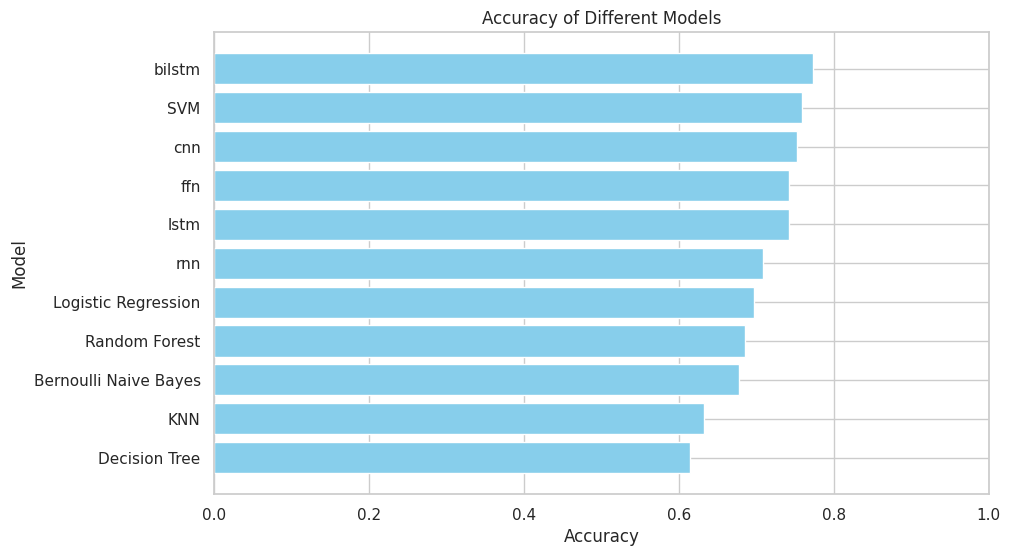

In [283]:
# Assuming you want to sort and plot the 'bert_scores' DataFrame
df = bert_scores.sort_values(by='accuracy', ascending=False)

plt.figure(figsize=(10, 6))

plt.barh(df['model'], df['accuracy'], color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Accuracy of Different Models')
plt.xlim(0, 1)
plt.gca().invert_yaxis()
plt.show()